In [1]:
#-----------------------------------------------------------------------
# Solution to the compressible Blasius equation (boundary value problem)
#
# 2 (ρ μ f'')' + f f'' = 0
# (ρ μ h')' + Pr f h' + Pr (γ-1) Ma^2 ρ μ (f'')^2 = 0
#
# where
#    f: Similarity form for the stream function = ψ/√(2 ν_∞ U x)
#    h: Specific enthalpy at the wall
#
# with isothermal bc:
#     f(0)  = f'(0) = 0 
#     f'(∞) = 1
#     h(∞)  = 1
#     h     = θ(0)
#
# following Howarth-Dorodnitsyn transformation 
#     θ     = T / T_∞
#-----------------------------------------------------------------------

In [2]:
using Plots
using Polynomials
using FastGaussQuadrature
using NLsolve
using Interpolations
using LinearAlgebra

In [77]:
default(linewidth=2)
γ  = 1.4;  # specific heat ratio
Pr = 0.7;  # Prandtl number
Ma = 5.0;  # Mach number

In [19]:
η_max = 10.0
N = 30
x_resid = gausslegendre(N-3)[1]
dx_dη = 2 / η_max

UnpackCheb(X) = ChebyshevT(X[1:N]), ChebyshevT(X[N+1:end]);

In [20]:
X = zeros(2N-1);

In [21]:
function CompressibleBlasiusResidual(X)
    f, h = UnpackCheb(X)
    f_η = derivative(f, 1) * dx_dη
    f_ηη = derivative(f_η, 1) * dx_dη
    f_ηηη = derivative(f_ηη, 1) * dx_dη
    h_η = derivative(h, 1) * dx_dη
    h_ηη = derivative(h_η, 1) * dx_dη
    blasius = 2 * f_ηηη + f_ηη * f
    blasius_h = h_ηη + Pr * f * h_η + Pr * (γ - 1) * Ma * Ma * f_ηη * f_ηη # enthalpy equation
    R = zeros(2N-1)
    R[1] = f(-1)
    R[2] = f_η(-1)
    R[3] = f_η(1.) - 1
    R[4:N] = blasius.(x_resid)
    R[N+1] = h(-1.) - 2
    R[N+2] = h(1) - 1
    R[N+3:end] = blasius_h.(x_resid)
    R
end

CompressibleBlasiusResidual (generic function with 1 method)

In [22]:
solution = nlsolve(CompressibleBlasiusResidual, X)
f, h = UnpackCheb(solution.zero)
f_η  = derivative(f, 1) * dx_dη
f_ηη = derivative(f_η, 1) * dx_dη;

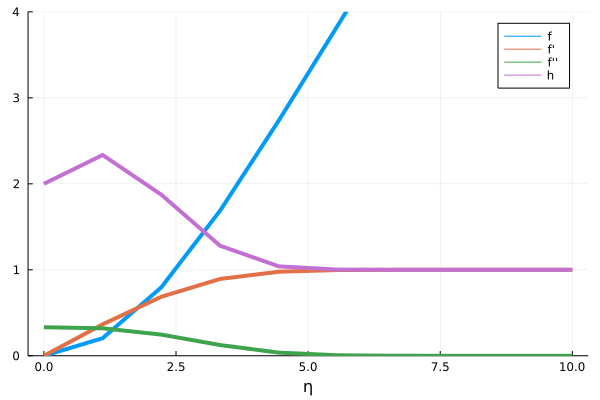

In [23]:
n = 10
x = LinRange(-1, 1, n)
η = (x .+ 1) * η_max / 2
plot(η, [f.(x) f_η.(x) f_ηη.(x) h.(x)], label=["f" "f'" "f''" "h"], ylim=(0, 4))
xlabel!("η")

In [106]:
# Interpolation
function interps(fun, x, η)
     flin = LinearInterpolation(η, fun.(x));
     fquad = extrapolate(scale(interpolate(fun.(x), 
                                           BSpline(Quadratic(Line(OnGrid())))
                                          ),
                               η
                              ),
                         Throw()
                        );
     fspline = CubicSplineInterpolation(η, fun.(x));
     return flin, fquad, fspline
end

TemperatureFromE(energy, velocity) = energy .- velocity .* velocity

function TemperatureFromConservative_interp(x, η, u, T)
     u_interps = interps(u, x, η);
     E_interps = interps(T + u*u, x, η);
     T_interps = []
     for i=1:3
         push!(T_interps, TemperatureFromE(E_interps[i], u_interps[i]))
         
     end
     return T_interps
 end
     


TemperatureFromConservative_interp (generic function with 2 methods)

In [107]:
u = f_η;
T = h;   # T = T_∞ * h

# primitive 
T_prim_interps = interps(T, x, η);  

# conservative
T_cons_interps = TemperatureFromConservative_interp(x, η, u, T);

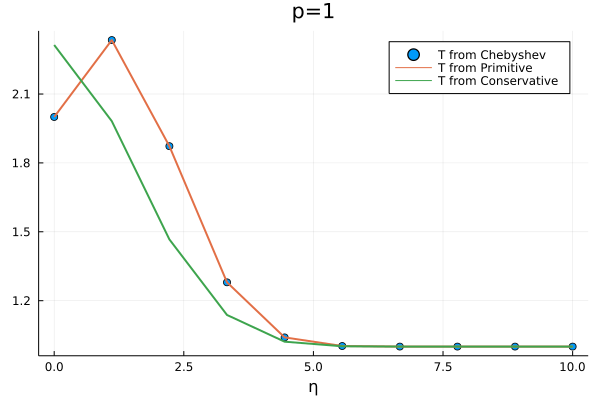

In [108]:
scatter(η, T.(x), label="T from Chebyshev")
plot!(η, [t->T_prim_interps[1](t), T_cons_interps[1]], 
      label=["T from Primitive" "T from Conservative"], 
      title="p=1", xlabel="η")

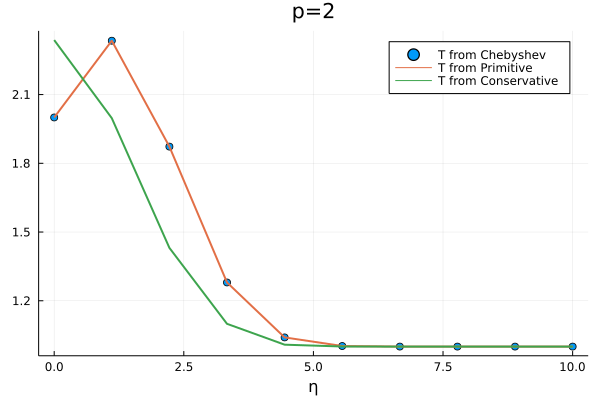

In [109]:
scatter(η, T.(x), label="T from Chebyshev")
plot!(η, [t->T_prim_interps[2](t), T_cons_interps[2]], 
      label=["T from Primitive" "T from Conservative"], 
      title="p=2", xlabel="η")

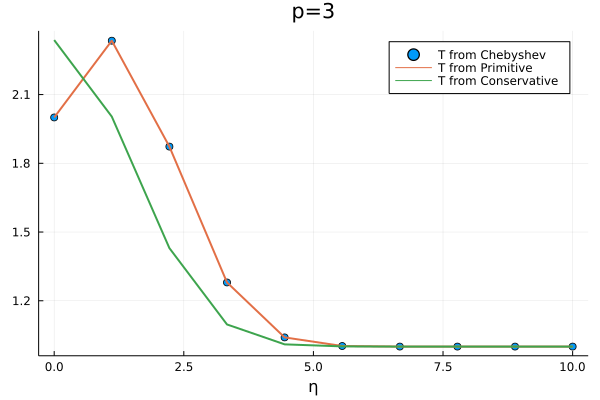

In [110]:
scatter(η, T.(x), label="T from Chebyshev")
plot!(η, [t->T_prim_interps[3](t), T_cons_interps[3]], 
      label=["T from Primitive" "T from Conservative"],  
      title="p=3", xlabel="η")